In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,  Trainer, TrainingArguments

In [19]:
no_nls_df = pd.read_csv("/Users/cisilkaraguzel/Documents/GitHub/NLSeer/csv_files/curated_mitochondrial_dataset.csv")
nls_df = pd.read_csv("/Users/cisilkaraguzel/Documents/GitHub/NLSeer/csv_files/finalized_complete_NLS_sequence_table.csv")
no_nls_df=no_nls_df.rename(columns={"Sequence": "Sequence_full"})
# Add a label column indicating presence (1) or absence (0) of nucleus localization signal
nls_df['has_signal'] = 1
no_nls_df['has_signal'] = 0
# Combine both datasets into one
combined_data_df = pd.concat([nls_df, no_nls_df], ignore_index=True)
combined_data_df["full_length"] = combined_data_df["Sequence_full"].apply(lambda x: len(x))
combined_data_df.to_csv("../csv_files/combined_data_df.csv", index=False)

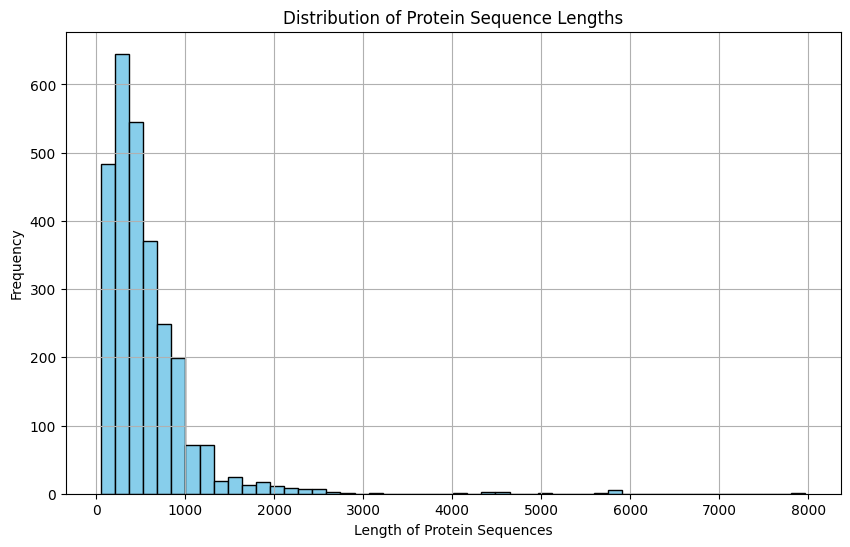

In [9]:
#looking at the length of sequences

lengths = combined_data_df['full_length']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Protein Sequence Lengths')
plt.xlabel('Length of Protein Sequences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=400):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(sequence, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)}

In [12]:
df= combined_data_df
selected_rows = pd.concat([df.iloc[0:4], df.iloc[2000:2004]])
# Reset index if needed
selected_rows = selected_rows.reset_index(drop=True)

In [17]:
# Load pre-trained BERT model and tokenizer
model_name = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


# Read the CSV file
data_df = selected_rows  # Replace "your_data.csv" with the path to your CSV file

# Split dataset into training and validation sets
train_data, val_data = train_test_split(data_df, test_size=0.2, random_state=42)

# Prepare datasets
train_dataset = ProteinDataset(train_data["Sequence_full"].tolist(), train_data["has_signal"].tolist(), tokenizer)
val_dataset = ProteinDataset(val_data["Sequence_full"].tolist(), val_data["has_signal"].tolist(), tokenizer)


# Define training parameters
batch_size = 2
epochs = 2
learning_rate = 2e-5

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    val_losses = []
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            val_losses.append(val_loss.item())
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, dim=1)
            val_predictions.extend(predicted_labels.tolist())
            val_labels.extend(labels.tolist())
    
    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_labels, val_predictions)
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1}: Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

# Save the trained model
model.save_pretrained("path_to_save_model_directory")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert_bfd and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/cisilkaraguzel/Documents/GitHub/NLSeer/.venv/lib/python3.12/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Validation Loss: 0.7111200094223022, Validation Accuracy: 0.5
Epoch 2: Validation Loss: 0.7065690755844116, Validation Accuracy: 0.5


In [ ]:
from torch.cuda.amp import autocast, GradScaler

# Define training parameters
batch_size = 32  # Increase the batch size
gradient_accumulation_steps = 16  # Accumulate gradients over multiple steps
epochs = 2
learning_rate = 2e-5

# Create DataLoader for training and validation sets with increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Mixed precision training
scaler = GradScaler()

# Training loop
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    # Validation loop
    model.eval()
    val_losses = []
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            val_losses.append(val_loss.item())
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, dim=1)
            val_predictions.extend(predicted_labels.tolist())
            val_labels.extend(labels.tolist())
    
    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_labels, val_predictions)
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1}: Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

# Save the trained model
model.save_pretrained("path_to_save_model_directory")
